In [1]:
import torch 
import torch.nn as nn
import pandas as pd
import torchvision
import tqdm
from PIL import Image
#from torchsummary import summary
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os


device = torch.device("cpu")
model = models.vgg16(pretrained=True)
model = model.to(device)

c:\Users\indtal\AppData\Local\anaconda3\envs\deepLearning\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\indtal\AppData\Local\anaconda3\envs\deepLearning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
new_classifier = nn.Sequential(*list(model.classifier.children())[:-7])
model.classifier = new_classifier

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # Subtracts the mean from each value and then divides by the standard deviation.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # resizes the images so the shortest side has a length of 256 pixels. 
        # The other side is scaled to maintain the aspect ratio of the image.
        transforms.Resize(256), 
        # crops the center of the image so it is a 224 by 224 pixels square image.
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
data_dir = 'hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


In [5]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x2fd4a72ac90>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x2fd4a6e5290>}

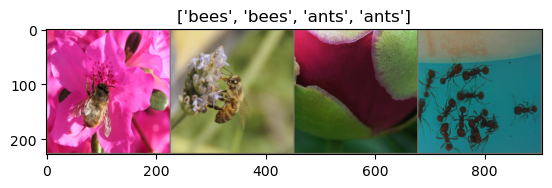

In [6]:
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
model.eval()
#model = model.cuda()

with torch.no_grad():
    features = None
    image_labels = None

    for data, label in tqdm.tqdm(dataloaders['train']):
        #x = data.cuda()
        output = model(data)

        if features is not None:
            features = torch.cat((features, output), 0)
            image_labels = torch.cat((image_labels, label), 0)
        else:
            features = output
            image_labels = label

    features = features.view(features.size(0), -1)


100%|██████████| 61/61 [01:19<00:00,  1.30s/it]


In [8]:
features.shape

torch.Size([244, 25088])

In [9]:
image_labels.shape

torch.Size([244])

Train a LR classifier using the features extracted by the VGG16 Classifier

In [10]:
features_np = features.cpu().numpy()
image_labels_np = image_labels.cpu().numpy()

In [11]:
features_np

array([[0.        , 0.        , 0.        , ..., 0.49759945, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.5361235 , 2.058921  , 2.4459715 , ..., 0.        , 0.        ,
        0.01036236],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.2016346 , 0.        , 2.9308963 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.0547986 , 2.0887551 ,
        0.4897725 ]], dtype=float32)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(features_np, image_labels_np, test_size=0.2, random_state = 7)

glm = LogisticRegression(C=0.1)
glm.fit(X_train,y_train)

LogisticRegression(C=0.1)

In [13]:
accuracy = glm.score(X_test, y_test)
print(f'Accuracy on validation set using Logistic Regression: {accuracy*100}%')

Accuracy on validation set using Logistic Regression: 89.79591836734694%


Run inferences on the test images

In [15]:
import os
image_names_test = os.listdir("hymenoptera_data/test")
image_paths_test = ["hymenoptera_data/test/"+ x for x in image_names_test]

In [26]:
print(image_names_test)

['147542264_79506478c2.jpg', '157401988_d0564a9d02.jpg', '159515240_d5981e20d1.jpg', '181171681_c5a1a82ded.jpg', '2103637821_8d26ee6b90.jpg', '239161491_86ac23b0a3.jpg', '400262091_701c00031c.jpg', '540976476_844950623f.jpg', '751649788_78dd7d16ce.jpg', '94999827_36895faade.jpg']


In [17]:
from torch.autograd import Variable

imsize = 224

loader = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

In [27]:
import random 

test_sample = random.sample(image_paths_test, 10)
model.eval() 

def test_img():
    result_lst = []
    for path in test_sample:
      image = image_loader(loader, path)
      output = model(image.to(device))
      output = output.cpu().detach().numpy() 
      result = glm.predict(output)
      result = 'bees' if float(result) >0.5 else 'ants'
      result_lst.append(result)
    return result_lst

In [28]:
# get test predictions from all models
pred_results = test_img()
pred_results

C:\Users\indtal\AppData\Local\Temp\ipykernel_5736\1780761919.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)
C:\Users\indtal\AppData\Local\Temp\ipykernel_5736\1447943931.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  result = 'bees' if float(result) >0.5 else 'ants'
C:\Users\indtal\AppData\Local\Temp\ipykernel_5736\1780761919.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)
C:\Users\indtal\AppData\Local\T

['bees',
 'ants',
 'bees',
 'bees',
 'ants',
 'ants',
 'bees',
 'ants',
 'bees',
 'bees']

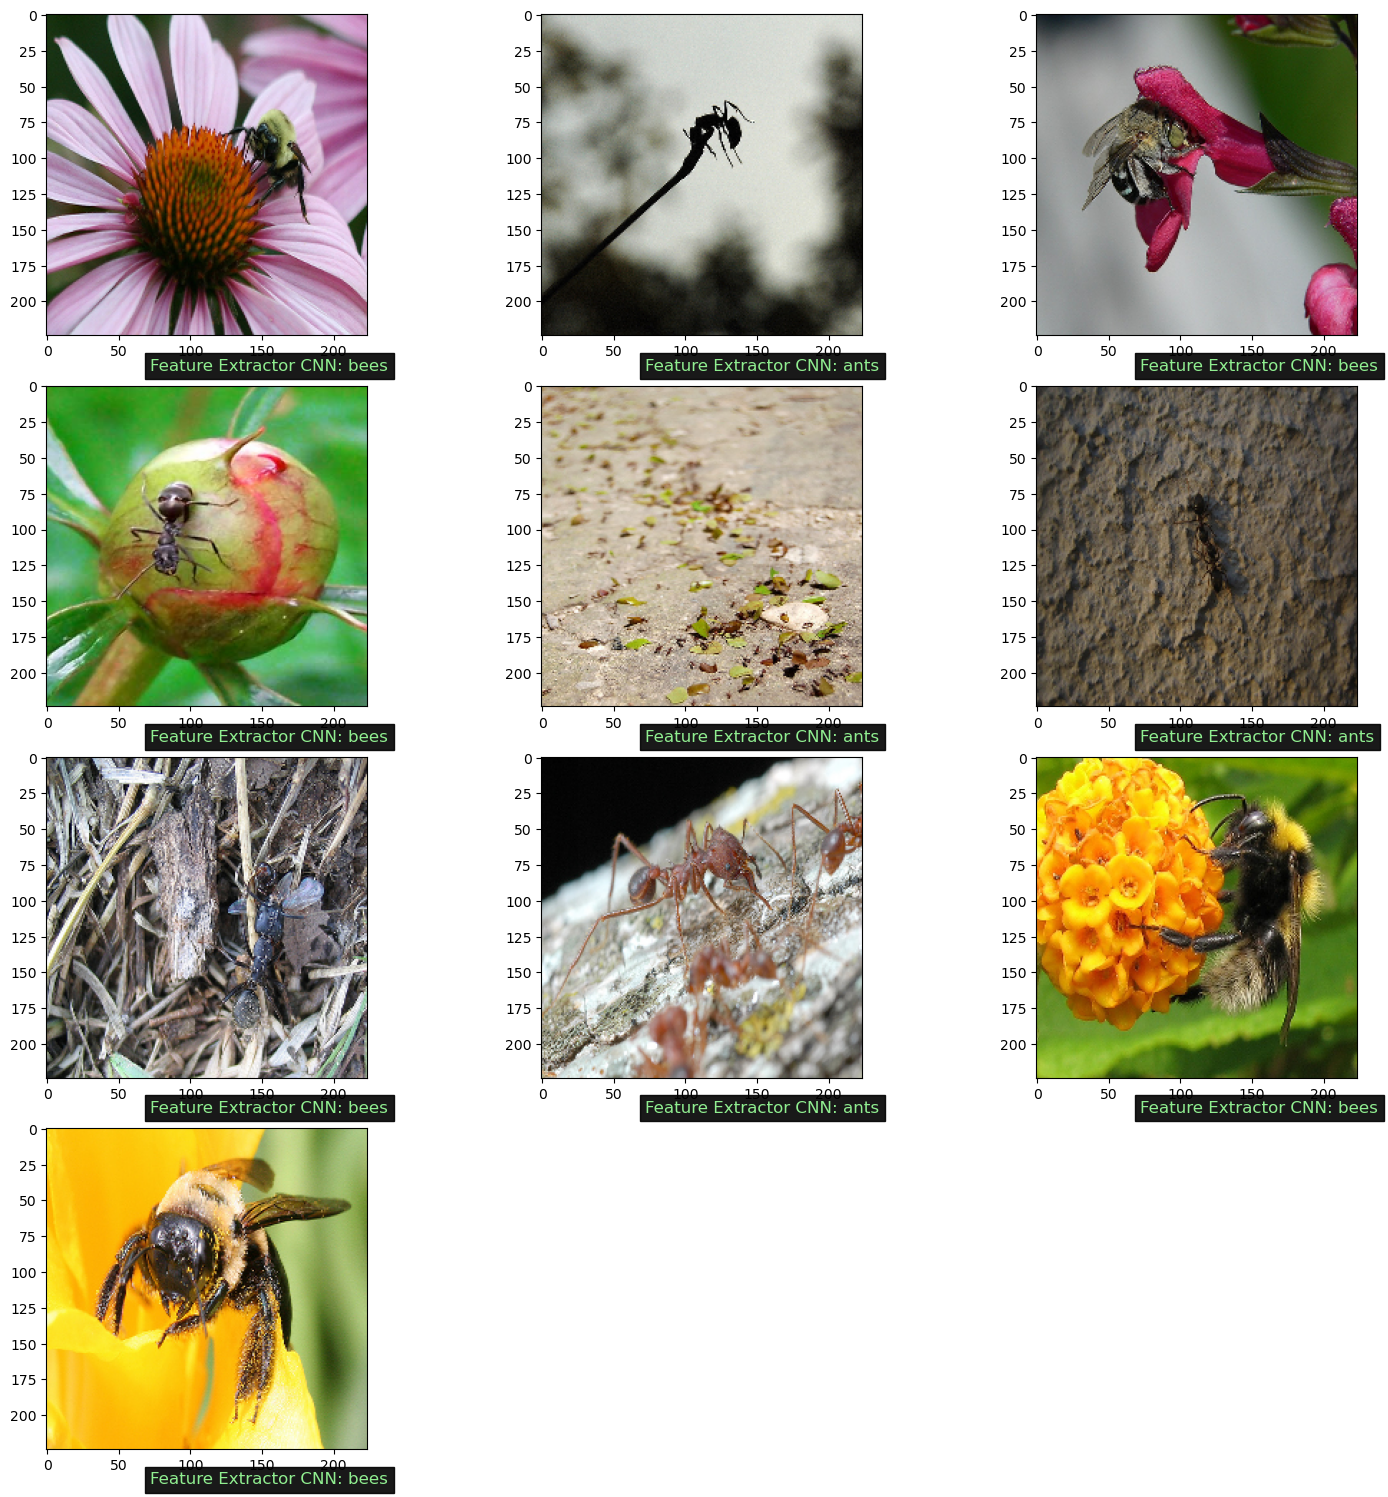

In [30]:
import cv2

plt.figure(figsize=(15, 15))

for i in range(0, 10):
    plt.subplot(4, 3, i+1)
    result = pred_results[i]
    img = test_sample[i]
    image = cv2.imread(img)
    image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.text(72, 248, f'Feature Extractor CNN: {result}', color='lightgreen',fontsize= 12, bbox=dict(facecolor='black', alpha=0.9))
    plt.imshow(image)

plt.tight_layout()
plt.show()